In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Given:
$$
n=3,\space a_0=0,\space a_1=1,\space a_2=1/2,\space a_3=-2
$$

Create a vector $\textbf{x} ∈ \mathbb{R}^m$ of $m = 10,000$ measurement points randomly sampled from a uniform distribution over the section [-1,1]

In [5]:
m = 10000
x = np.random.uniform(low=-1, high=1, size=m)
x

array([-0.22096148,  0.73421892, -0.56889663, ...,  0.55422361,
        0.24241625, -0.93817522])

For this vector $x$ calculate $f(x_i)=a_0+a_1x_i+a_2x_i^2+a_3x_i^3,\space i=1,2,...,m$

In [6]:
n = 3
a_0 = 0
a_1 = 1
a_2 = 1/2
a_3 = -2

f = a_0 + a_1 * x + a_2 * x**2 + a_3 * x**3
f

array([-0.17497306,  0.21215594, -0.03883568, ...,  0.36733064,
        0.24330758,  1.15342367])

Create the vector $\textbf{y}$, where $y_i=f(x_i)+w_i, \space i=1,2,...,m$ by adding Gaussian noise $w_i$ with variance $σ^2 = 0.5$ to each of the measurements.

In [7]:
variance = 0.5
w = np.random.normal(loc=0, scale=np.sqrt(variance), size=m)
y = f + w
y

array([-0.14803129, -0.98337638,  0.00852292, ..., -0.10131157,
        0.07680215,  1.39099027])

#**Part 1**

Create the X matrix,<br>
and calculate the estimated vector of coefficients $\textbf{a*}$ for the vectors $\textbf{x}$ and $\textbf{y}$

In [94]:
# Create the X matrix
X = np.column_stack([x**j for j in range(n+1)])

# Compute the estimated coefficients
X_transpose = np.transpose(X)
XtX = np.dot(X_transpose, X)
XtX_inverse = np.linalg.inv(XtX)
Xty = np.dot(X_transpose, y)
a_star = np.dot(XtX_inverse, Xty)
a_star

array([-0.00319313,  0.97878372,  0.48175398, -1.96479068])

As you can see $\textbf{a*}$ is approximated quite well to the original coefficients $a_0=0,\space a_1=1,\space a_2=1/2,\space a_3=-2$

Draw on one graph in the segment [-1,1]:<br>
• The polynom $f(\textbf{x})$.<br>
• The vector of the noisy measurements $\textbf{y}$. <br>
• The estimated polynom $\hat{f}(\textbf{x})$

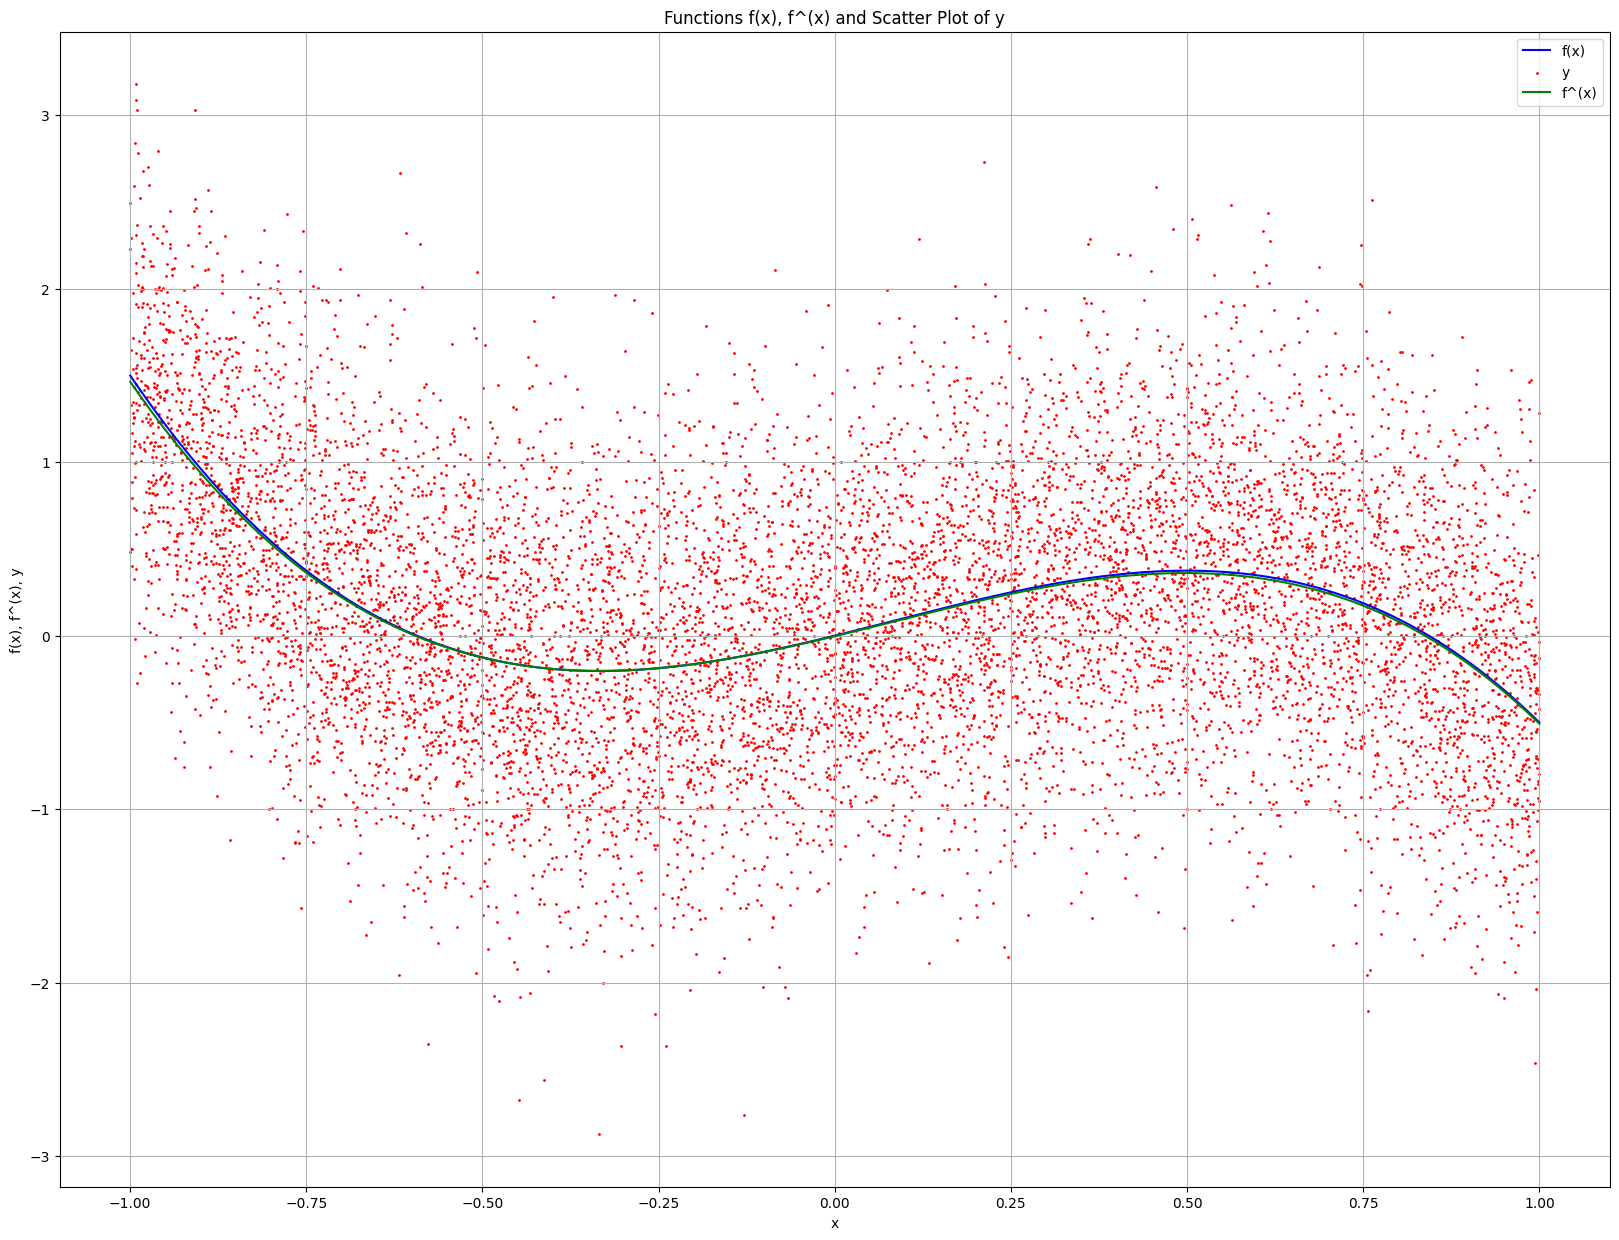

In [96]:
#Calculate the estimated polynom f^(x)
#f_estimated = a_star[0] + a_star[1] * x + a_star[2] * x**2 + a_star[3] * x**3
f_estimated = np.dot(X,a_star)
#Plot the graph
plt.figure(figsize=(20, 15))
plt.plot(sorted(x), f[np.argsort(x)], c='blue', label='f(x)')
plt.scatter(x, y, c='red', label='y',s=1)
plt.plot(sorted(x), f_estimated[np.argsort(x)], c='green', label='f^(x)')
plt.xlabel('x')
plt.ylabel('f(x), f^(x), y')
plt.title('Functions f(x), f^(x) and Scatter Plot of y')
plt.legend()
plt.grid(True)
plt.show()

As you can see from the graph, although the $\textbf{y}$ samples are very scattered, we received a successful estimation of $\textbf{a}$, because both functions - the original and the estimated one - converge each other on the graph.

#**Part 2**

Define the parameters

In [8]:
# Define the parameters
n = 3           # Number of coefficients - a_0, a_1, a_2, ..., a_(n+1)
r = 4           # Radius of sphere C
epsilon = 0.0001  # Define the treshold of the solutions gradient
N = 100000        # Maximal number of iterations

1. Define the function generating starting point $\textbf{a}_0 \sim N(0,I)$ that suits the condition $\|\textbf{a}_0\|_2\le r$

In [9]:
def choose_a_0(n,N,r):                        # Function receives n- size of the point vector, N - maximal number of iterations to find right a_0, r - radius of the sphere of C
  for i in range(N):                        # define the loop of maximal N iterations to find the right a_0
    mean = np.zeros(n+1)                      # Mean vector of zeros
    covariance = np.eye(n+1)                  # Identity covariance matrix
    a_0 = np.random.multivariate_normal(mean, covariance) # Generate random a_0 in normal distribution with given mean and covarience
    norm_a_0 = np.linalg.norm(a_0, ord=2)   # Calculate the 2-norm of 'a'
    if norm_a_0 <= r:                       # Check if a_0 suits the condition norm_a_0 <= r
      break                                 # If a_0 is not suits the condition norm_a_0 <= r, continue generate new a_0
  return a_0 if i<N else mean               # Returns the point shape (n,1) : a_0 if succed or 0 if not succed

In [135]:
# example: a_0 for given n and N
print(choose_a_0(n,N,r))

[ 0.08522714  0.18533179 -0.94618589  0.45334945]


Define function grad(a), that calculates
$\nabla h(a) = \frac{1}{m}\times (\textbf{a}^TX^TX-\textbf{y}^TX)$

In [10]:
def grad(a, XtX, ytX):
  g = (1/m)* (np.dot(a,XtX)-ytX)
  return g

Define the function that checks if the gradient of received solution is below the threshold to stop running of the algorithm: $\lvert\lvert \nabla h(a) \rvert\rvert_2 \le \epsilon $

In [11]:
def is_less_then_epsilon(g, epsilon):
  norm_g = np.linalg.norm(g, ord=2)  # Calculate the 2-norm of 'g'
  return True if norm_g<=epsilon else False

Define the function that calculates a projection on the C, where C is defined :
 $C=\{ \textbf{a} \in \mathbb{R}^{n+1}:\|{\textbf{a}}\|_2 \le r \}$ <br>
and:
\begin{equation}
  \Pi_C(\textbf{a})=\left\{\begin{array}{@{}l@{}}
   r\cdot\frac{\textbf{a}}{\|\textbf{a}\|_2}, \textbf{a} \notin C\\
    \textbf{a} ,\qquad \textbf{a}\in C
  \end{array}\right.\,.
\end{equation}

In [12]:
def project_onto_C(a, r):
   # Check if a is in C.
  if np.linalg.norm(a) <= r:
    return a  # if a in C, return a

  # if a not in C, project a onto C.
  a_normalized = a / np.linalg.norm(a, ord=2)
  projected_a = r * a_normalized

  return projected_a

Define the function that calculates next step size $\eta$.<br>
Function eta_1 returns Diminishing step size depending on step number $t$<br>
Function eta_2 returns AdaGrad step size depending the current step gradient norm, and all previous steps gradients norms.

In [13]:
# Diminishing step size calculation function
def eta_1(t, D, G, gradient, g_sq_sum):
  return D/(G*np.sqrt(t)), g_sq_sum

# AdaGrad step size calculation function
def eta_2(t, D, G, gradient, g_sq_sum):
  g_sq_sum+=np.linalg.norm(gradient, ord=2) **2
  return D/(np.sqrt(2*g_sq_sum)), g_sq_sum


Define the function that computes the target function $h(a)=\frac{1}{2m} \|\textbf{y}-X\textbf{a}\|_2^2$

In [14]:
def target_function(a, y, X):
  Xa = np.dot(X,a)
  return (1/2/m) * (np.linalg.norm((y-Xa),ord=2)**2)

Define the function that implements the Projected Gradient Algorithm for the problem (P')<br>
Function Projected_Gradient_1 recieves the vectors $\textbf{x}$ and $\textbf{y}$, recieves the Diminishing step size, and returns $\textbf{a}^*$ - the solution of optimization problem (P')<br>
Args:<br>
$\qquad$x:$\quad$ A vector of shape (m,1)<br>
$\qquad$y:$\quad$ A vector of shape (m,1)<br>
$\qquad$key:$\quad$ A function name that returns the diminishing step size.<br>

Returns:<br>
$\qquad$A vector of shape (n,)<br>

Function Projected_Gradient_2 recieves the vectors $\textbf{x}$ and $\textbf{y}$, recieves the AdaGrad step size, and returns $\textbf{a}^*$ - the solution of optimization problem (P')<br>

In [15]:
def Projected_Gradient(x, y, n, r, N, epsilon, step_calc = eta_1):

  # Create the X matrix
  X = np.column_stack([x**j for j in range(n+1)])

  # Compute the estimated matricies
  X_transpose = np.transpose(X)
  XtX = np.dot(X_transpose, X)
  Xty = np.dot(X_transpose, y)
  ytX = np.transpose(Xty)

  # Compute of maximal eigenvalue of XtX/m
  m = len(x)
  max_eigenvalue = np.linalg.eig(XtX/m)[0].max()
  # Compute G - Lipshitz's constant
  G = 2 * r * max_eigenvalue + np.linalg.norm(Xty/m, ord=2)
  D = 2 * r         # Diameter D = diamC = 2r
  # Choose a_0 and assign to a_t
  a_t = choose_a_0(n,N,r)
  # Create empty array to store errors
  errors = np.empty([])
  # Compute the target function for the solution , for a_sol = {0, 1, 1/2, -2}
  h_sol = target_function(np.array([0, 1, 0.5, -2]), y, X)
  # Compute the target function for the first point of iterations a_t
  h_t = target_function(a_t, y, X)
  # Store the error into the errors array
  errors = np.append(errors,h_t-h_sol)
  # Set variable to store the sum of gradients of previous iterations
  g_sq_sum = 0
  # run the Projected Gradient algorithm maximum N iterations: t={1, 2, ..., N}
  for t in range(1,N):
    # Compute the gradient in given point a_t
    g_t = grad(a_t, XtX, ytX)
    # FOR_DEBUG #print("Norm g_t = ",np.linalg.norm(g_t,ord=2), " t = ",t)
    # Stop running if the norm of the gradient is below the threshold
    if is_less_then_epsilon(g_t, epsilon):
      break
    # Compute the next iteration step size
    step_size, g_sq_sum = step_calc(t, D, G, g_t, g_sq_sum)

    # Compute next point a
    a_t = project_onto_C((a_t-step_size*g_t), r)
    # Compute the target function for the first point of iterations a_t
    h_t = target_function(a_t, y, X)
    # Store the error into the errors array
    errors = np.append(errors,h_t-h_sol)
  #print(errors)
  return t, errors, a_t


In [16]:
it_num1, errors1, a_star1 = Projected_Gradient(x,y,n,r,N,epsilon,step_calc=eta_1)
print("a_star1 = ",a_star1)
print("Iterations number = ",it_num1)
print("Errors list : ",errors1)

a_star1 =  [-0.01912427  1.00482794  0.54176103 -1.98244044]
Iterations number =  50155
Errors list :  [ 2.22923544e+00  7.95303896e-01  3.58995080e-01 ... -1.33101089e-04
 -1.33101128e-04 -1.33101167e-04]


In [17]:
it_num2, errors2, a_star2 = Projected_Gradient(x,y,n,r,N,epsilon,step_calc=eta_2)
print("a_star2 = ",a_star2)
print("Iterations number = ",it_num2)
print("Errors list : ",errors2)

a_star2 =  [-0.01912454  1.0048679   0.54176196 -1.98250436]
Iterations number =  298
Errors list :  [ 1.79450456e+00  1.27209431e+00  8.11521437e+00  1.33778362e+00
  1.56417281e-01  3.82136242e-02  2.59189914e-02  2.37942614e-02
  2.27234330e-02  2.18056256e-02  2.09418417e-02  2.01176478e-02
  1.93290206e-02  1.85736359e-02  1.78496187e-02  1.71553090e-02
  1.64891992e-02  1.58499059e-02  1.52361527e-02  1.46467565e-02
  1.40806155e-02  1.35367004e-02  1.30140461e-02  1.25117448e-02
  1.20289406e-02  1.15648241e-02  1.11186285e-02  1.06896259e-02
  1.02771239e-02  9.88046327e-03  9.49901522e-03  9.13217944e-03
  8.77938217e-03  8.44007459e-03  8.11373131e-03  7.79984905e-03
  7.49794541e-03  7.20755780e-03  6.92824243e-03  6.65957337e-03
  6.40114172e-03  6.15255482e-03  5.91343549e-03  5.68342139e-03
  5.46216431e-03  5.24932965e-03  5.04459576e-03  4.84765348e-03
  4.65820556e-03  4.47596623e-03  4.30066071e-03  4.13202476e-03
  3.96980429e-03  3.81375496e-03  3.66364175e-03  3.51

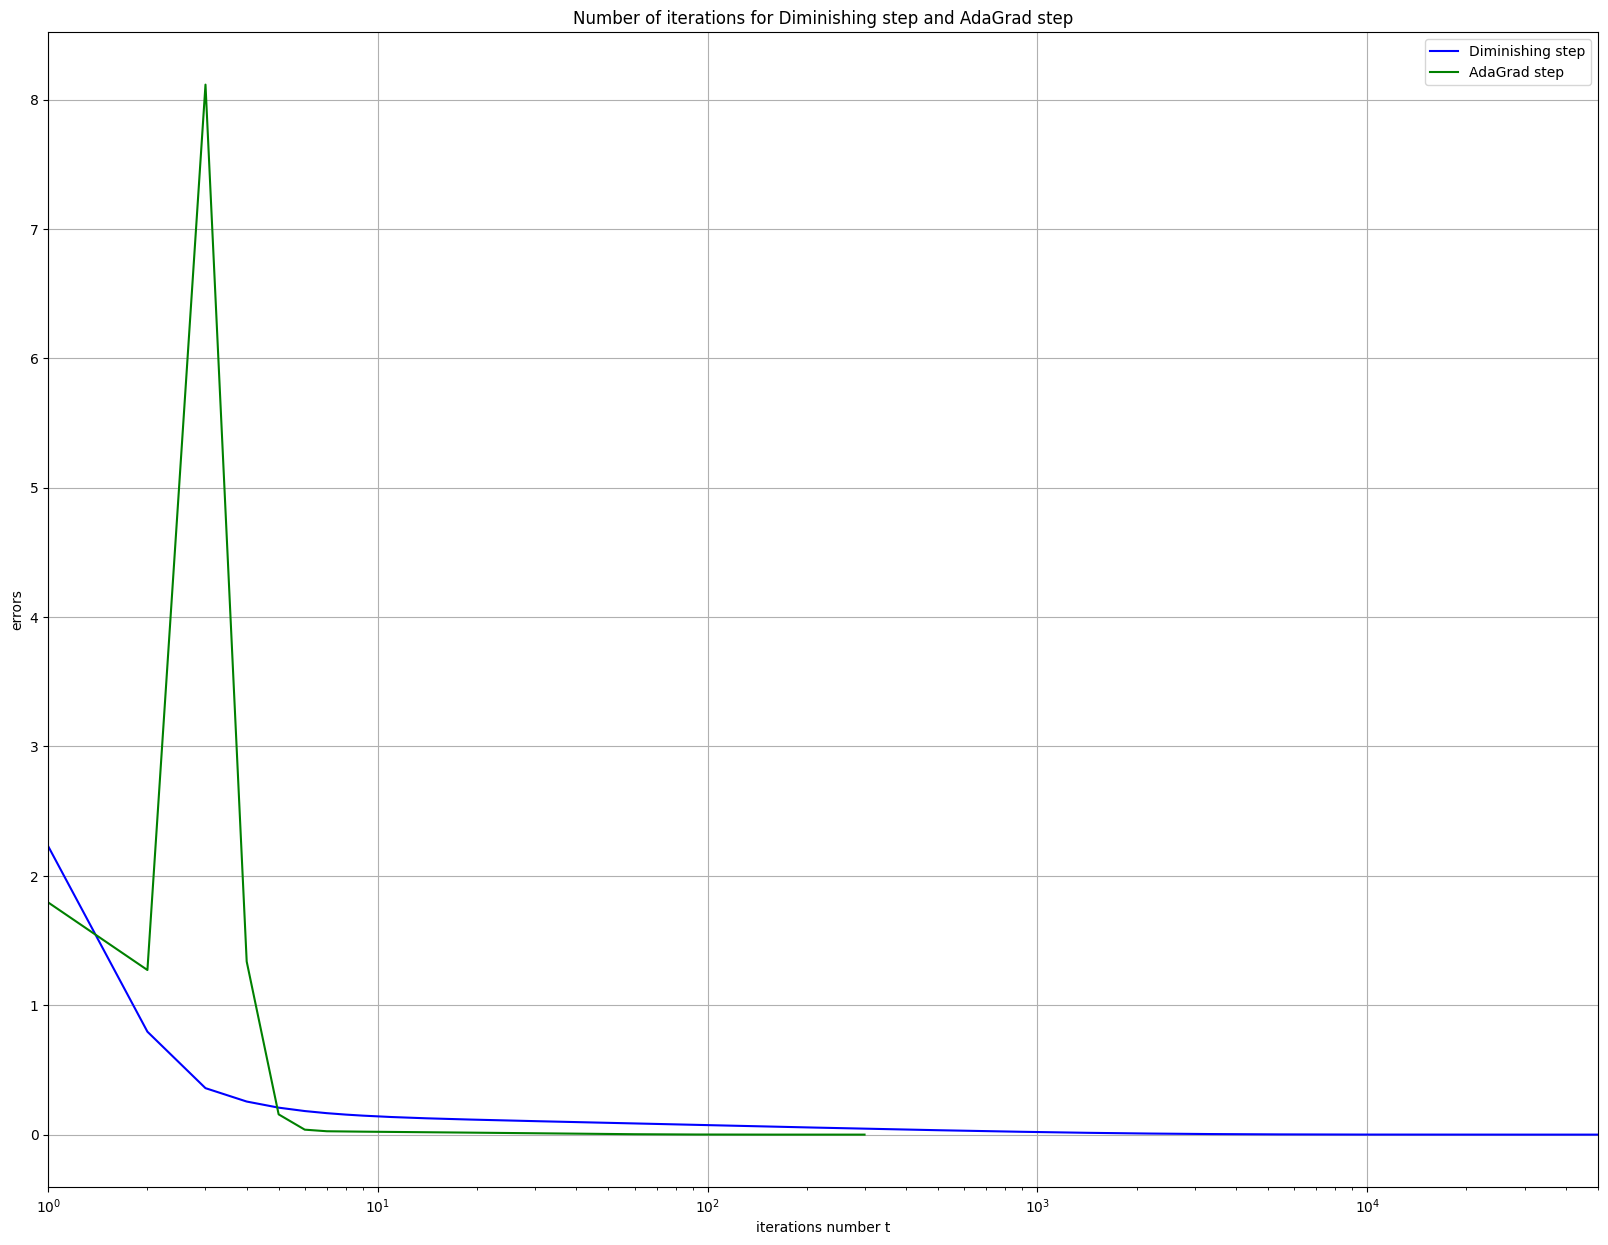

In [35]:
x1 = np.arange(1,len(errors1)+1)
x2 = np.arange(1,len(errors2)+1)

#Plot the graph
plt.figure(figsize=(20, 15))
plt.plot(x1,errors1, c='blue', label='Diminishing step')
plt.plot(x2,errors2, c='green', label='AdaGrad step')
plt.xscale('log')
plt.xlim(1, len(errors1))
plt.xlabel('iterations number t')
plt.ylabel('errors')
plt.title('Number of iterations for Diminishing step and AdaGrad step')
plt.legend()
plt.grid(True)
plt.show()